In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import cv2

CONFIGURATION

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATASET_PATH = '/content/drive/MyDrive/chest_xray'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DATA LOADING

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.1,
                                   horizontal_flip=True, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


RQ1 & RQ2: MODEL SETUP

In [5]:
def build_transfer_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False

    inputs = Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model, base_model

def build_scratch_model():
    inputs = Input(shape=(*IMG_SIZE, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(train_generator.num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

resnet_model, resnet_base = build_transfer_model()
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

scratch_model = build_scratch_model()
scratch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
resnet_model.fit(train_generator, validation_data=val_generator, epochs=5)
scratch_model.fit(train_generator, validation_data=val_generator, epochs=5)

# Evaluation
resnet_preds = resnet_model.predict(test_generator)
scratch_preds = scratch_model.predict(test_generator)
true_labels = test_generator.labels

print("ResNet50 Classification Report:")
print(classification_report(true_labels, np.argmax(resnet_preds, axis=1)))
print("\nScratch Model Classification Report:")
print(classification_report(true_labels, np.argmax(scratch_preds, axis=1)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1271s 10s/step - accuracy: 0.7291 - loss: 0.5925 - val_accuracy: 0.7421 - val_loss: 0.5420
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1100s 8s/step - accuracy: 0.7485 - loss: 0.5211 - val_accuracy: 0.7478 - val_loss: 0.4959
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1084s 8s/step - accuracy: 0.7425 - loss: 0.4921 - val_accuracy: 0.7555 - val_loss: 0.4727
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1082s 8s/step - accuracy: 0.7745 - loss: 0.4443 - val_accuracy: 0.7737 - val_loss: 0.4556
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1083s 8s/step - accuracy: 0.7710 - loss: 0.4535 - val_accuracy: 0.7824 - val_loss: 0.4383
Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.7841 - loss: 1.3193 - val_accuracy: 0.8667 - val_loss: 0.3227
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.9164 - loss: 0.2210 - val_accuracy: 0.8811 - val_loss: 0.2443
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.9279 - loss: 0.1816 - val_accura

RQ3: GRAD-CAM

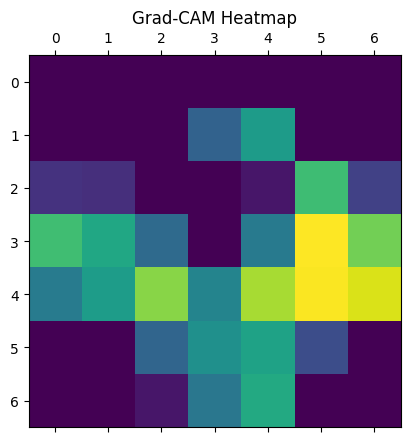

In [6]:
def make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Get the output of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(base_model.input, last_conv_layer.output)

    # Create model from last conv layer output to final predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    x = GlobalAveragePooling2D()(x)
    x = Dense(train_generator.num_classes, activation='softmax')(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        conv_outputs = last_conv_layer_model(img_array)
        tape.watch(conv_outputs)
        predictions = classifier_model(conv_outputs)
        class_idx = tf.argmax(predictions[0])
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Visualize heatmap
img_path = test_generator.filepaths[0]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array / 255., axis=0)
# Convert to tensor using model's input signature
img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
img_array = tf.ensure_shape(img_array, (1, 224, 224, 3))

# Automatically find the last valid conv layer
last_conv_layer_name = [layer.name for layer in resnet_base.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
heatmap = make_gradcam_heatmap(img_array, resnet_model, resnet_base, last_conv_layer_name)

plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.show()